# Text Retriveal - Group 1968850

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from tqdm import tqdm_notebook
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
DATA_DIR = '/content/drive/MyDrive/jan_group_projects/text/data/'

In [ ]:
try:
  articles = pd.read_csv(DATA_DIR + 'articles.csv')
  
except:
  articles_1 = pd.read_csv(DATA_DIR + 'articles1.csv', index_col=0)
  articles_2 = pd.read_csv(DATA_DIR + 'articles2.csv', index_col=0)
  articles_3 = pd.read_csv(DATA_DIR + 'articles3.csv', index_col=0)

  articles = pd.concat([articles_1, articles_2, articles_3])

  del articles_1
  del articles_2
  del articles_3

  articles.to_csv(DATA_DIR + 'articles.csv', index=False)
articles.head()

,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [32]:
print(len(articles), '\n')
print(articles.isna().sum())

142570 

id                 0
title              2
publication        0
author         15876
date            2641
year            2641
month           2641
url            57011
content            0
dtype: int64


In particular, there are many missing values on a date, but since we will only extract and use data for a specific year, we ignore the missing values first.

## Describe the corpus

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


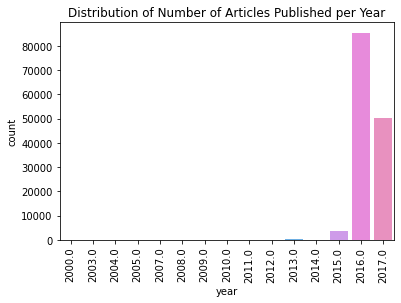

In [ ]:
# Display the distribution of number of articles published per year

sns.countplot(articles['year'])
plt.xticks(rotation=90)
plt.title('Distribution of Number of Articles Published per Year')
plt.show()

Since there are many articles with no year indicated, we will use articles from 2016 and 2017, which are relatively recent, to specify the year.

In [ ]:
# Select one specific year you will study further, select 4 publications

# YEAR = 2017
# PUBLICATIONS = Guardian, CNN, Washington Post, New York Times

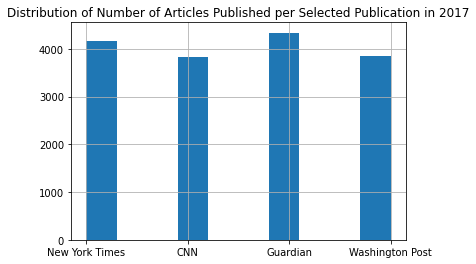

In [ ]:
# Display the split between the 4 publications in your year of study

articles[(articles['year'] == 2017) & 
          (articles['publication'].isin(['Guardian', 'CNN', 'Washington Post', 'New York Times']))]['publication'].hist()
plt.title('Distribution of Number of Articles Published per Selected Publication in 2017')
plt.show()

The New York Times, CNN, Guardian, and Washington Post were selected.

In [ ]:
# Consider only the articles published during the selected year bythe selected 4 publications

df = articles[(articles['year'] == 2017) & 
              (articles['publication'].isin(['Guardian', 'CNN', 'Washington Post', 'New York Times']))]
df.head(3)

,id,title,publication,author,date,year,month,url,content
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."


In [ ]:
# Consider only the articles published during the selected year by the selected 4 publications

df = articles[(articles['year'] == 2017) & 
              (articles['publication'].isin(['Guardian', 'CNN', 'Washington Post', 'New York Times']))]
df.head(3)

,id,title,publication,author,date,year,month,url,content
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."


Here, we only extract and use the above four newspapers written in 2017.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


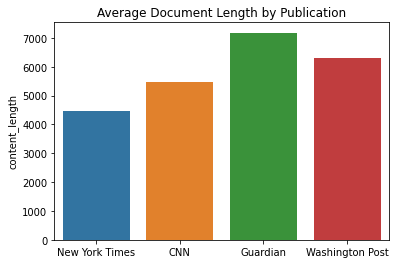

In [ ]:
# Illustrate description with statistics

# Average document length

df['content_length'] = df['content'].apply(lambda x: len(x))

sns.barplot(df.publication.unique(), df.groupby('publication').mean()['content_length'])
plt.title('Average Document Length by Publication')
plt.show()

The average length article was the shortest in the New York Times and the longest in the Guardian at 7,000 words.

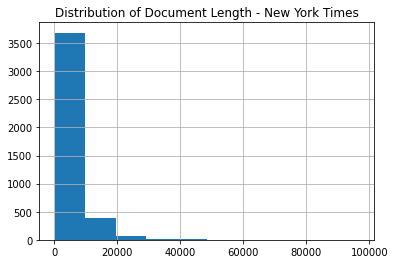

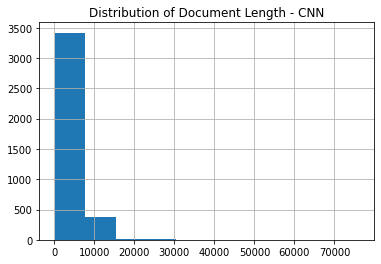

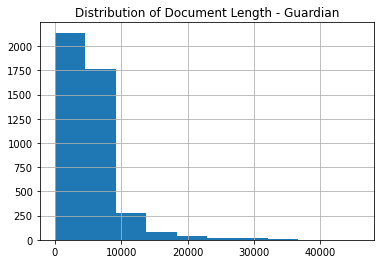

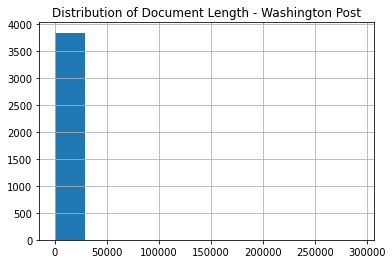

In [ ]:
# Distribution of document length 

df[df['publication'] == 'New York Times']['content_length'].hist()
plt.title('Distribution of Document Length - New York Times')
plt.show()
df[df['publication'] == 'CNN']['content_length'].hist()
plt.title('Distribution of Document Length - CNN')
plt.show()
df[df['publication'] == 'Guardian']['content_length'].hist()
plt.title('Distribution of Document Length - Guardian')
plt.show()
df[df['publication'] == 'Washington Post']['content_length'].hist()
plt.title('Distribution of Document Length - Washington Post')
plt.show()

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('cnn')

def clean_text(docs):
    cleaned_docs = []
    for doc in tqdm_notebook(docs):
        doc = doc.lower()
        # Only alphabets
        temp_doc = re.sub("[^a-zA-Z ]", "", doc)
        cleaned_docs.append(temp_doc)
    return cleaned_docs

def split_pub(publication):
    df_selected = df[df['publication'] == publication]
    data = []
    for c, p in zip(df_selected['content'], df_selected['publication']):
        temp = [c, p]
        data.append(temp)
    return data

def tokenize_data(data):
    tokenized_data = []
    for line in tqdm_notebook(range(len(data))):
        tokenized = word_tokenize(data[line][0])
        tokenized = list(set(tokenized) - set(stopwords))
        tokenized_data.append(tokenized)
    return tokenized_data

def wc_generator(data):
    total_tokens = [token for doc in data for token in doc]
    text = nltk.Text(total_tokens)
    data = text.vocab().most_common(50)
    wordcloud = WordCloud(relative_scaling=0.2,
                          background_color='white',
                          ).generate_from_frequencies(dict(data))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Text cleansing
cleansed_data = clean_text(df['content'])
df['content'] = cleansed_data
# Split by publications
data_guardian = split_pub('Guardian')
data_cnn = split_pub('CNN')
data_wp = split_pub('Washington Post')
data_nyt = split_pub('New York Times')
# Text tokenize
tk_guardian = tokenize_data(data_guardian)
tk_cnn = tokenize_data(data_cnn)
tk_wp = tokenize_data(data_wp)
tk_nyt = tokenize_data(data_nyt)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Most Frequent Words in - Guardian


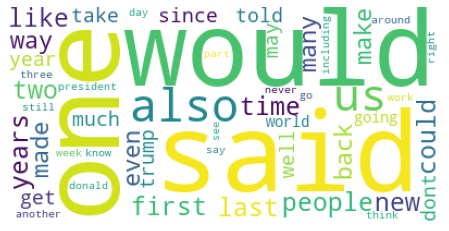

Most Frequent Words in - CNN


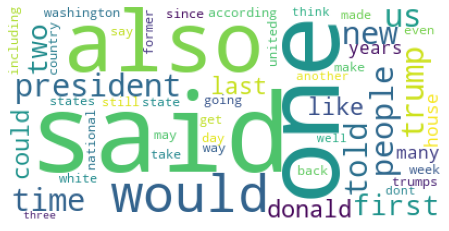

Most Frequent Words in - Washington Post


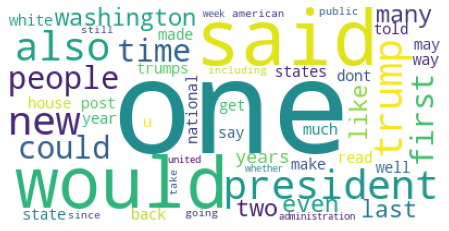

Most Frequent Words in - New York Times


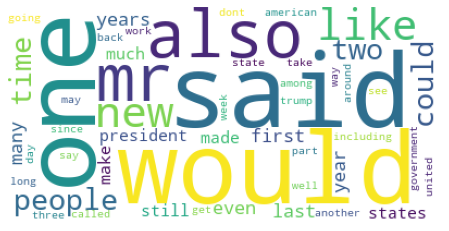

In [ ]:
# Most frequent words per publication (Word cloud)

print('Most Frequent Words in - Guardian')
wc_generator(tk_guardian)
print('Most Frequent Words in - CNN')
wc_generator(tk_cnn)
print('Most Frequent Words in - Washington Post')
wc_generator(tk_wp)
print('Most Frequent Words in - New York Times')
wc_generator(tk_nyt)

We used word cloud to show the most frequent words. As a result of extracting the first word cloud, it was determined that the article written in CNN was not fair when it was classified because the CNN was written inside the article, so it was added to the default stopwords list of nltk and filtered.

# Preprocess the corpus

In [ ]:
# concat texts

tokenized_text = tk_guardian + tk_cnn + tk_wp + tk_nyt
print(len(tokenized_text))

16177


In [ ]:
# Create the Dictionary & Frequency Filtering

def build_doc_term_mat(documents):
    # Create dictionary
    dictionary = corpora.Dictionary(documents)
    # Frequency filtering 
    dictionary.filter_extremes(no_below=5, no_above=0.9)
    dictionary.compactify()
    # Corpus
    corpus = [dictionary.doc2bow(documents[idx]) for idx in tqdm_notebook(range(len(documents)))]
    
    return corpus, dictionary

corpus, dictionary = build_doc_term_mat(tokenized_text)

print(dictionary)


Dictionary(43376 unique tokens: ['absolutely', 'access', 'according', 'achieve', 'achieving']...)


For more meaningful topic extraction, filter extreme was performed to reduce the size of the dictionary.

In [ ]:
# Stopwords
# Stopwords were defined earlier.
# Stemming will be performed later.
print(stopwords[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


## Study your corpus with Topic Modeling


[K=4] Coherence:  -0.6568439325517786
[K=4] Perplexity:  -8.984947170412426 



[K=5] Coherence:  -0.6740720593103375
[K=5] Perplexity:  -8.98260748939266 



[K=6] Coherence:  -0.724810801623856
[K=6] Perplexity:  -8.984236177236044 



[K=7] Coherence:  -0.7061984842563136
[K=7] Perplexity:  -8.991735395132242 



[K=8] Coherence:  -0.7967285118876595
[K=8] Perplexity:  -8.996404411395797 



[K=9] Coherence:  -0.7776357457087051
[K=9] Perplexity:  -8.99076416783617 



[K=10] Coherence:  -0.8415080261465553
[K=10] Perplexity:  -8.994096860396125 



[K=11] Coherence:  -0.9353194761592792
[K=11] Perplexity:  -8.99957852081448 



[K=12] Coherence:  -1.1203311715730482
[K=12] Perplexity:  -9.000955899439706 



[K=13] Coherence:  -0.906218641712543
[K=13] Perplexity:  -9.000328908900924 



[K=14] Coherence:  -2.056847238902346
[K=14] Perplexity:  -9.01196677152873 



[K=15] Coherence:  -2.105467076073504
[K=15] Perplexity:  -9.01163221546468 



[K=16] Coherence:  -2.27911622840348

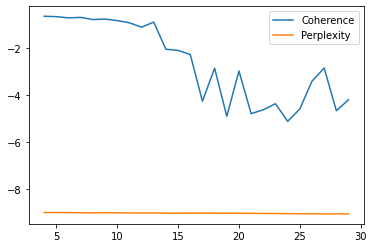

In [ ]:
# Select a value for K (num topics)

coherence_lst = []
perplexity_lst = []

# From 4 to 30 find optimal K
for K in tqdm_notebook(range(4, 30)):
    # Define lda_model
    lda_model = models.ldamodel.LdaModel(corpus, num_topics=K, 
                                         id2word=dictionary, alpha="auto", eta="auto",
                                         iterations=200, random_state=100)
    # For metrics
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    perplexity = lda_model.log_perplexity(corpus)
    # Save the evaluation for visualization
    coherence_lst.append(coherence)
    perplexity_lst.append(perplexity)
    print("=" * 75)
    print()
    print("[K={}] Coherence: ".format(K), coherence)
    print("[K={}] Perplexity: ".format(K), perplexity, "\n")
    print()
# Visualize
plt.plot(range(4, 30), coherence_lst)
plt.plot(range(4, 30), perplexity_lst)
plt.legend(['Coherence', 'Perplexity'])
plt.show()

Since high coherence and low perplexity are important when measuring the performance of topic modeling, we chose 13 as the most sensible K value based on this experiment.

In [ ]:
# Perform LDA on your corpus

OPTIMAL_K = 13
NUM_TOPICS_WORDS = 30

def print_topic_words(model):
  for topic_id in range(model.num_topics):
    topic_word_probs = model.show_topic(topic_id, NUM_TOPICS_WORDS)
    print("Topic ID: {}".format(topic_id))
    for topic_word, prob in topic_word_probs:
        print("\t{}\t{}".format(topic_word, prob))
    
    print("\n")

lda_model = models.ldamodel.LdaModel(corpus, num_topics=OPTIMAL_K, 
                                     id2word=dictionary, alpha="auto", eta="auto",
                                     iterations=200, random_state=100)
print_topic_words(lda_model)

Topic ID: 0
	like	0.0021702456288039684
	one	0.0019181077368557453
	time	0.0018882867880165577
	way	0.0017718664603307843
	people	0.0017388792475685477
	years	0.0016804520273581147
	much	0.0016515955794602633
	would	0.001639131223782897
	life	0.001634998363442719
	dont	0.0016244769794866443
	go	0.001615965273231268
	also	0.0016105733811855316
	first	0.0015446697361767292
	get	0.0015173503197729588
	something	0.0015060536097735167
	back	0.0014922689879313111
	day	0.001490371418185532
	even	0.0014769956469535828
	two	0.0014509481843560934
	long	0.0014430005103349686
	around	0.0014424821129068732
	think	0.0014324195217341185
	work	0.001400599954649806
	family	0.0014003528049215674
	really	0.0013757613487541676
	said	0.0013490598648786545
	little	0.001347591052763164
	many	0.0013429408427327871
	im	0.001340896007604897
	see	0.0013157419161871076


Topic ID: 1
	one	0.002206348115578294
	like	0.0020183364395052195
	said	0.0019942482467740774
	made	0.001827997388318181
	even	0.001809409586712

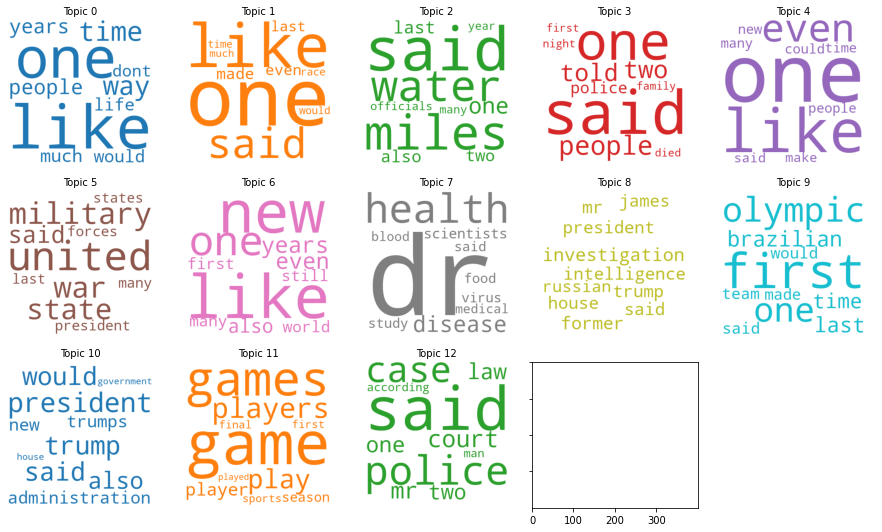

In [47]:
# See Topics as Word Cloud

nb_columns = 5
nb_rows = 3

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(OPTIMAL_K / len(cols))

cloud = WordCloud(background_color='white',
                  width=400,
                  height=400,
                  max_words=10,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=OPTIMAL_K, num_words=10, formatted=False)

fig, axes = plt.subplots(ncols=nb_columns, nrows=nb_rows, 
                         figsize=(2.5*nb_columns, 2.5*nb_rows), 
                         sharex=True, sharey=True)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title('Topic ' + str(i), fontdict=dict(size=10))
    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

1. Topic 0: Opinion news
2. Topic 1: General politics
3. Topic 2: Environment 
4. Topic 3: Police & Crime
5. Topic 4: Business/ Economic
6. Topic 5: Middle east war
7. Topic 6: World
8. Topic 7: Medical news
9. Topic 8: Donald Trump & White House
10. Topic 9: Olympic Game
11. Topic 10: Politics & Republicans & Donald Trump
12. Topic 11: Sports Game
13. Topic 12: Police & Crime


In [ ]:
# Select a topic from LDA, annotate it by giving it a name
topic_names = ["Opinion news", "General politics", "Environment", "Police & Crime",
               "Business/ Economic", "Middle east war", "World", "Medical News",
               "Donald Trump & White House", "Olympic game", "Politics & Republicans & Donald Trump",
               "Sports game", "Police & Crime"]
print(len(topic_names))

13


In [ ]:
# Top 10 articles with highest saturation in your topic

selected_lst = []

for idx in tqdm_notebook(range(len(corpus))):
    topic, prob = sorted(lda_model.get_document_topics(corpus[idx], minimum_probability=0), 
                         key=lambda x: x[1], reverse=True)[0]
    selected_lst.append((idx, topic, prob))

top_art_0 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==0, x[2]), reverse=True)[:10]]
top_art_1 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==1, x[2]), reverse=True)[:10]]
top_art_2 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==2, x[2]), reverse=True)[:10]]
top_art_3 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==3, x[2]), reverse=True)[:10]]
top_art_4 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==4, x[2]), reverse=True)[:10]]
top_art_5 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==5, x[2]), reverse=True)[:10]]
top_art_6 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==6, x[2]), reverse=True)[:10]]
top_art_7 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==7, x[2]), reverse=True)[:10]]
top_art_8 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==8, x[2]), reverse=True)[:10]]
top_art_9 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==9, x[2]), reverse=True)[:10]]
top_art_10 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==10, x[2]), reverse=True)[:10]]
top_art_11 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==11, x[2]), reverse=True)[:10]]
top_art_12 = [idx for idx, _, _2 in sorted(selected_lst, key=lambda x: (x[1]==12, x[2]), reverse=True)[:10]]
top_arts = [top_art_0, top_art_1, top_art_2, top_art_3, 
            top_art_4, top_art_5, top_art_6, top_art_7, 
            top_art_8, top_art_9, top_art_10, top_art_11, top_art_12]

for topic, tp_name in zip(top_arts, topic_names):
    print('Top 10 Articles - {}'.format(tp_name))
    print()
    for i in topic:
        print('No.{}'.format(i))
        print("" + " ".join(tokenized_text[i][:30]) + "...")
        print()
    print()
    print("="*100)


Top 10 Articles - Opinion news

No.3209
clothes us youre near drink half week better compliments first nowhere eating comes cover body comments bad reasons think sore email dont oh trying much searching want breasts ache keep...

No.6295
us hospital company retiring another day times voice simple need provide dreaded boy inevitable early alone four ward give volunteering arent hospitals leave jensen youve snuggle first help love rockers...

No.194
market kitchen us bottle hooked everyone youre another interested year times test paper sugar mystified favourite culinary without ago replied bake ardche daily asked couple leave minutes mood asparagus concrete...

No.5005
publicity important hard experiencing us else honor economic everyone youre day enter passionate aside decades giving need simple family watched diamond fees raised involved born history ended mom woman thats...

No.16001
set important books walking suggested kitchen visit countrys incorporate everyone youre day another p

## Predict a publication

### Classifier based on Bag of Words

In [ ]:
# Concat
all_data = data_guardian + data_cnn + data_wp + data_nyt
all_data_tokenized = []
for line in tqdm_notebook(range(len(all_data))):
    tokenized = word_tokenize(all_data[line][0])
    for s in stopwords:
        if s in tokenized:
            tokenized.remove(s)
    all_data_tokenized.append((tokenized, all_data[line][1]))

In [ ]:
p_stemmer = PorterStemmer()

X = []
for idx in tqdm_notebook(range(len(all_data_tokenized))):
    doc = all_data_tokenized[idx][0]
    # perform stemming
    temp = [p_stemmer.stem(word) for word in doc]
    temp = ' '.join(temp)
    X.append(temp)

y = []
for _, label in all_data_tokenized:
    if label == 'Guardian':
        encoded = 0
    elif label == 'CNN':
        encoded = 1
    elif label == 'Washington Post':
        encoded = 2
    else:
        encoded = 3
    y.append(encoded)

In [ ]:
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

In [ ]:
# Pipeline
model = Pipeline([
                 ('vect', CountVectorizer()),                        # Count vectorizer
                 ('clf', XGBClassifier(n_estimators=200, n_jobs=-1)) # XGBClassifier
                 ])

model.fit(X_train, y_train)
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       881
           1       0.90      0.79      0.84       759
           2       0.88      0.88      0.88       748
           3       0.96      0.90      0.93       848

    accuracy                           0.87      3236
   macro avg       0.88      0.87      0.87      3236
weighted avg       0.88      0.87      0.87      3236



### Classifier based on Topic Modeling

In [ ]:
# Get vectors of previous lda model
lda_vecs = lda_model[corpus]
# Fit it to the right input format
doc_topics = np.zeros((len(corpus), OPTIMAL_K))
for i in tqdm_notebook(range(len(corpus))):
    topics = lda_vecs[i]
    for t in topics:
        t_idx, p = t
        doc_topics[i][t_idx] = p

X_lda = doc_topics.copy()
# Same y

# Train / test split
X_train_lda, X_test_lda, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=156)

# Train the model (XGBClassifier)
lda_clf = XGBClassifier(n_estimators=200, n_jobs=-1)
lda_clf.fit(X_train_lda, y_train)
pred_lda = lda_clf.predict(X_test_lda)
print(classification_report(y_test, pred_lda))


              precision    recall  f1-score   support

           0       0.51      0.43      0.47       881
           1       0.43      0.50      0.46       759
           2       0.41      0.40      0.41       748
           3       0.46      0.48      0.47       848

    accuracy                           0.45      3236
   macro avg       0.45      0.45      0.45      3236
weighted avg       0.46      0.45      0.45      3236



### Explain the difference in accuracy (BoW model vs Topic Modelling model)

We trained a classifier with 13-dimensional topic modeling vectors as inputs and a bag of words-based model using Count Vectorizer. The first model, the bow model, showed good performance with f1 scores of 0.8 to 0.9 for each class. On the other hand, the lda vector-based model showed an f1 score of about 0.4, giving significantly lower performance than the first model.

In [31]:
print(lda_vecs[0])
print()
print(X_lda[0])

[(2, 0.046039086), (4, 0.23289293), (5, 0.2935324), (6, 0.010789716), (10, 0.4151772)]

[0.         0.         0.04599468 0.         0.23289444 0.29349086
 0.01079091 0.         0.         0.         0.41526043 0.
 0.        ]


The above array is shows the vector values of the first document returned from the lda model and the first X values created according to the 13-dimensional input shape. We concluded two main reasons why the performance of the lda model was degraded. First, only 5 vectors were returned from the lda model, and very sparse input data was created with all 8 other features being 0. Second, it was considered that the vector values extracted from the topic modeling did not have a effect in classifying the publishers because there is no news topic especially handled by each newspaper publishers.  
  
In conclusion, the bow model made it possible to easily classify publications since there were specific keywords or frequently used words for each publisher. However, it turns out that the vector input generated form the lda model is insufficient in discriminating publications.